# I. Preparation

In [60]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [61]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [62]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [63]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [64]:
table = 8

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (3,20)

# Frequency range from which to collect Gaussians
bn = (3,20)

## 3. Parameters that should stay fixed

In [65]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [66]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')
        
#                                 # Plot PSD
#                                 fig, ax = plt.subplots(figsize=[15, 4])
#                                 plot_spectrum(freq, power, log_powers=True, label=channel, ax=ax)
#                                 plot_spectrum_shading(freq, power, [7, 12], log_powers=True, ax=ax)
#                                 plt.show()

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
                                        
        # Fit FOOOF model per target
        for (powers, target) in zip((powers_50, powers_55, powers_60, powers_65), \
                                    (50, 55, 60, 65)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=False)[0][0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[0][0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[0][1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[0][2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=False)[1][0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[1][0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[1][1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[1][2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=False)[2][0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[2][0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[2][1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[2][2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     2.4872, 102.6628, 2.0745                                     
                                                              

C:\Users\ThinkPad\anaconda3\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)



                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     0.4711, -1.6423, 0.5565                                      
                                                                                                  
                                       2 peaks were found:                                        
         

# III. Descriptive statistics
## 1. Summary

In [67]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [68]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,50,2.487202,102.662804,2.074514,9.505280,0.826092,2.369051,1,0.947597,0.080683
1,S1,/Day1,55,3.765459,2005.550537,3.199116,9.215099,0.817649,2.000000,3,0.955425,0.065216
2,S1,/Day1,55,3.765459,2005.550537,3.199116,9.215099,0.817649,2.000000,3,0.955425,0.065216
3,S1,/Day1,55,3.765459,2005.550537,3.199116,11.180996,0.279208,2.000000,3,0.955425,0.065216
4,S1,/Day1,55,3.765459,2005.550537,3.199116,18.464607,0.414522,3.003062,3,0.955425,0.065216


In [69]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,593.00,593.00,593.00,593.00,593.00,593.00,593.00,593.00,593.00
mean,2.65,53937.92,2.24,10.01,0.39,2.15,2.15,0.94,0.07
std,1.39,744122.81,1.05,3.18,0.23,0.39,0.64,0.04,0.02
min,-2.29,-6.44,0.00,3.20,0.01,2.00,1.00,0.68,0.03
25%,1.68,1.59,1.42,6.99,0.22,2.00,2.00,0.92,0.05
50%,2.69,79.80,2.16,10.02,0.35,2.00,2.00,0.95,0.07
75%,3.45,450.65,2.89,11.51,0.51,2.00,3.00,0.97,0.08
max,7.96,16731123.00,5.99,20.00,1.11,4.00,4.00,0.99,0.15
skewness,0.28,20.01,0.40,0.96,0.90,2.99,0.01,-2.25,0.89
kurtosis,1.02,434.05,0.11,1.44,0.53,8.79,-0.29,9.01,1.05


## 2. Univariate plots

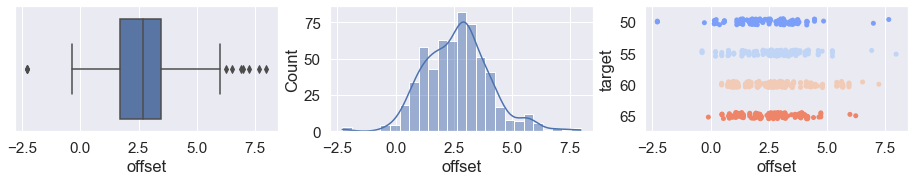

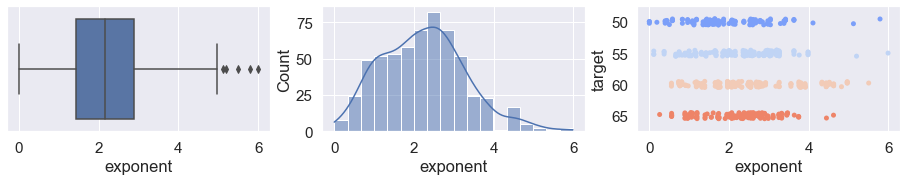

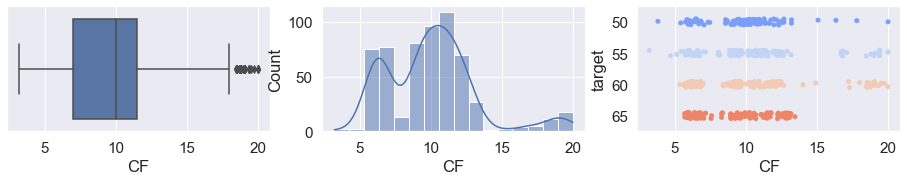

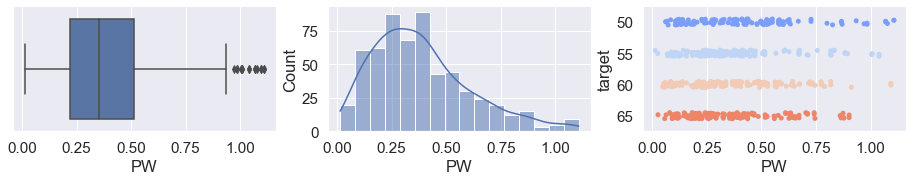

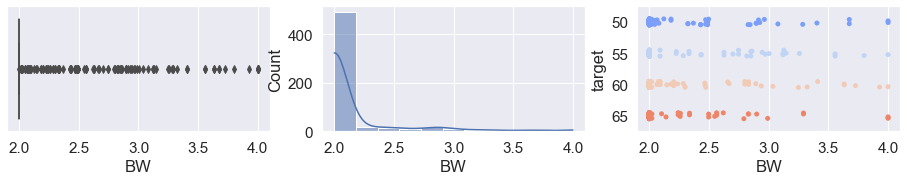

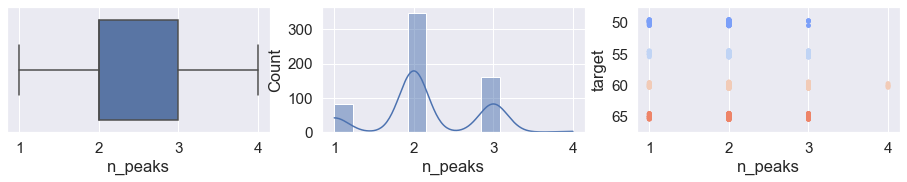

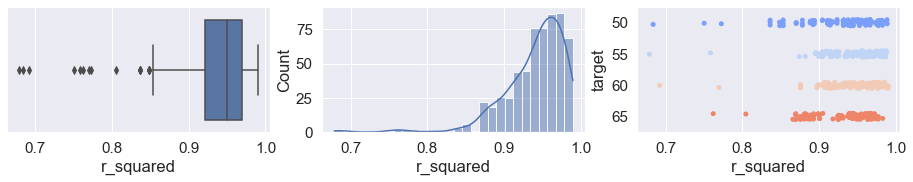

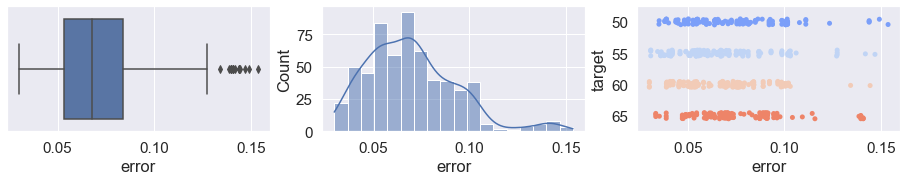

Done in 11.880s


In [70]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

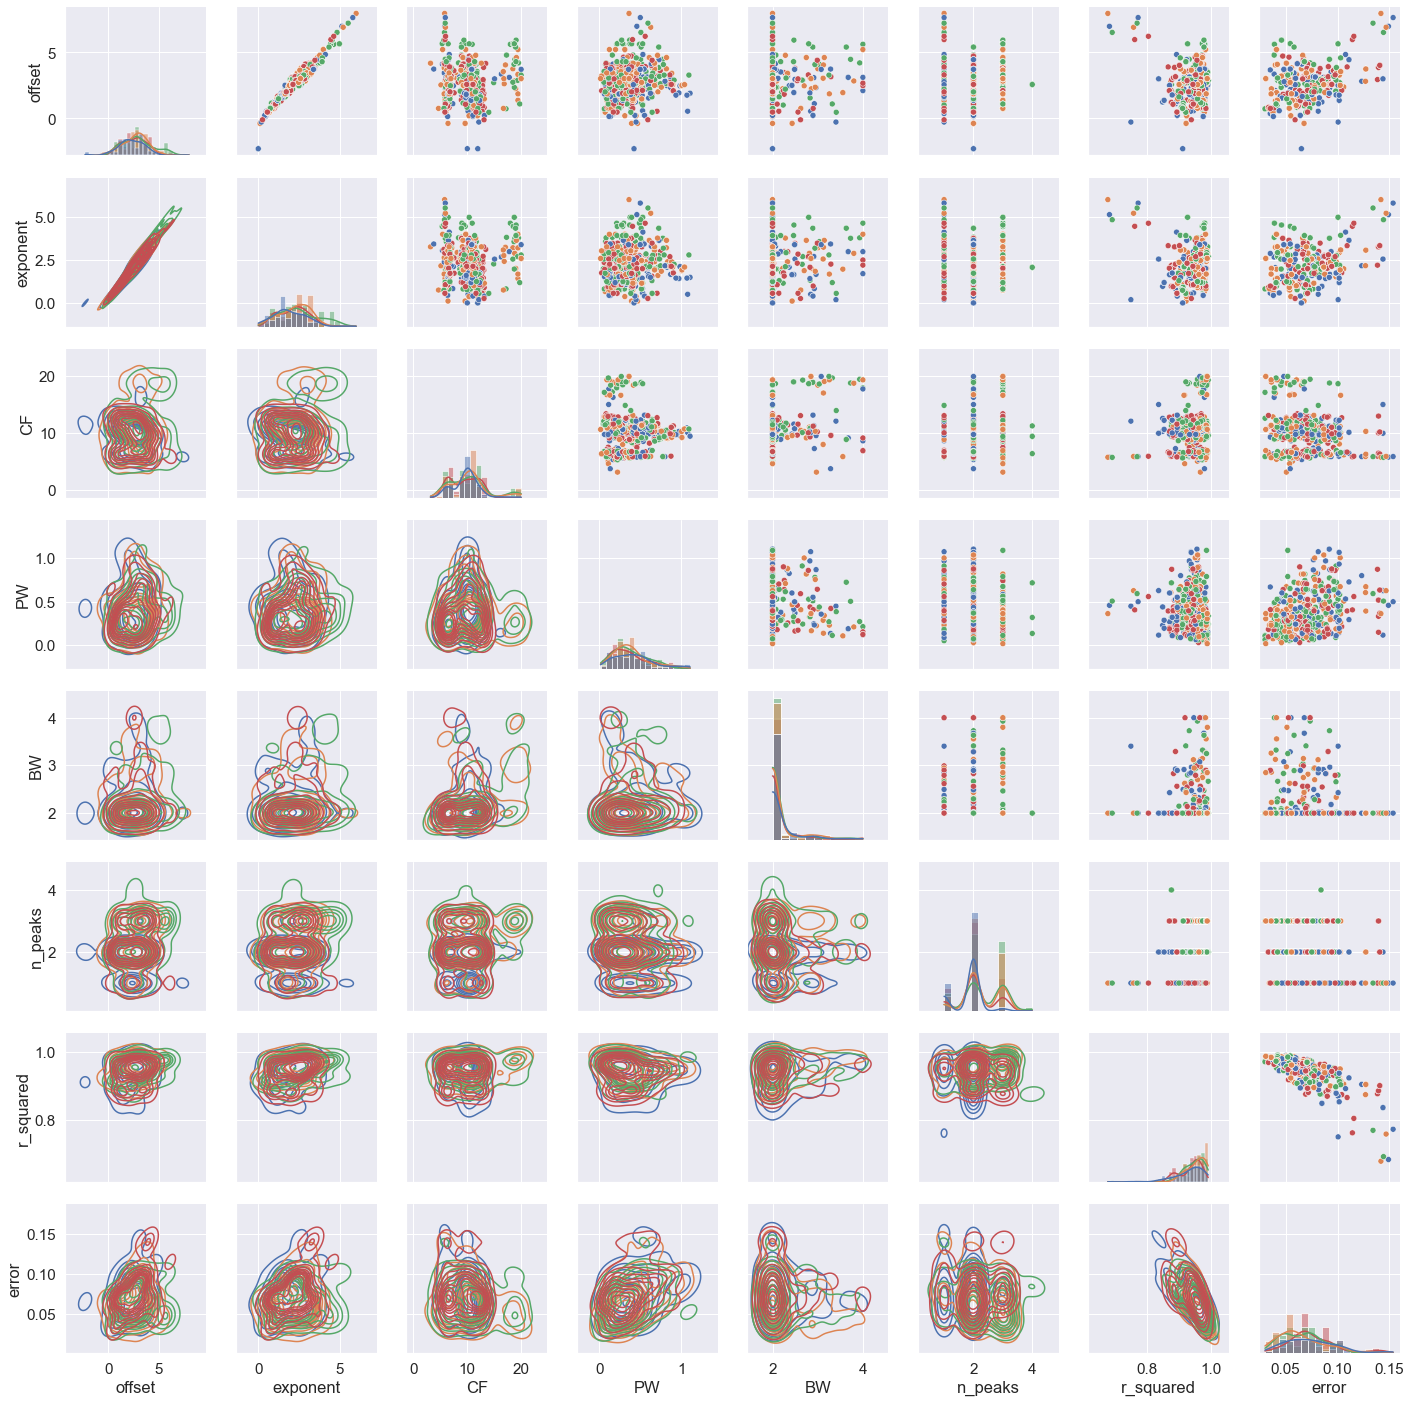

Done in 66.811s


In [71]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.25,0.97,-0.01,0.14,0.10,0.13,0.00,0.26
knee,0.25,1.00,0.24,-0.09,0.02,-0.02,-0.12,-0.37,0.21
exponent,0.97,0.24,1.00,0.03,0.08,0.12,0.12,0.07,0.21
CF,-0.01,-0.09,0.03,1.00,0.00,0.30,0.12,0.13,-0.17
PW,0.14,0.02,0.08,0.00,1.00,-0.01,-0.12,-0.11,0.36
BW,0.10,-0.02,0.12,0.30,-0.01,1.00,-0.06,0.09,-0.08
n_peaks,0.13,-0.12,0.12,0.12,-0.12,-0.06,1.00,0.16,-0.14
r_squared,0.00,-0.37,0.07,0.13,-0.11,0.09,0.16,1.00,-0.71
error,0.26,0.21,0.21,-0.17,0.36,-0.08,-0.14,-0.71,1.00


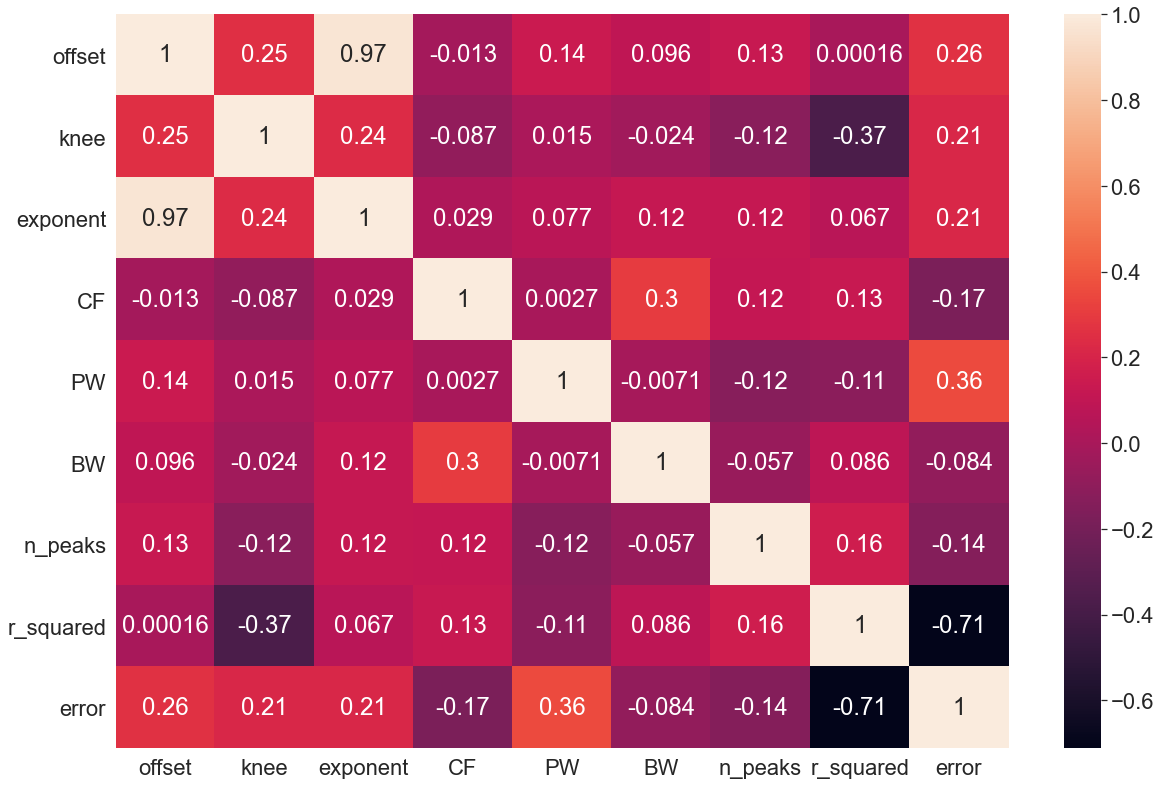

In [72]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [73]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


## 1. Logistic regression

Feature: 0, Score: -0.33028
Feature: 1, Score: 1.07680
Feature: 2, Score: -0.04833
Feature: 3, Score: -0.03857
Feature: 4, Score: 0.08175
Feature: 5, Score: 0.16102
Feature: 6, Score: -0.47647
Feature: 7, Score: -0.01995
Feature: 8, Score: 0.25780


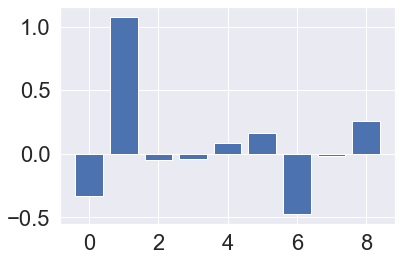

              precision    recall  f1-score   support

          50       0.27      0.26      0.26        27
          55       0.41      0.32      0.36        41
          60       0.33      0.39      0.36        28
          65       0.25      0.30      0.27        23

    accuracy                           0.32       119
   macro avg       0.31      0.32      0.31       119
weighted avg       0.33      0.32      0.32       119

Feature: 0, Score: -0.29398
Feature: 1, Score: 0.34350
Feature: 2, Score: -0.00383
Feature: 3, Score: -0.08420
Feature: 4, Score: 0.13227
Feature: 5, Score: 0.06104
Feature: 6, Score: -0.44440
Feature: 7, Score: -0.16604
Feature: 8, Score: 0.08364


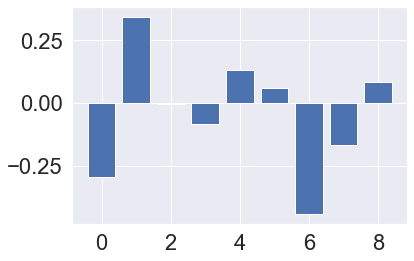

              precision    recall  f1-score   support

          50       0.38      0.53      0.44        19
          55       0.38      0.29      0.33        41
          60       0.33      0.37      0.35        30
          65       0.29      0.28      0.28        29

    accuracy                           0.34       119
   macro avg       0.34      0.37      0.35       119
weighted avg       0.34      0.34      0.34       119

Feature: 0, Score: -0.33195
Feature: 1, Score: 0.72054
Feature: 2, Score: 0.02315
Feature: 3, Score: -0.00833
Feature: 4, Score: 0.03229
Feature: 5, Score: 0.10930
Feature: 6, Score: -0.53823
Feature: 7, Score: -0.00499
Feature: 8, Score: 0.17802


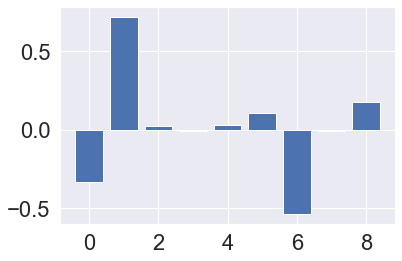

              precision    recall  f1-score   support

          50       0.28      0.30      0.29        23
          55       0.33      0.31      0.32        35
          60       0.31      0.38      0.34        26
          65       0.24      0.20      0.22        35

    accuracy                           0.29       119
   macro avg       0.29      0.30      0.29       119
weighted avg       0.29      0.29      0.29       119

Feature: 0, Score: -0.06075
Feature: 1, Score: 0.23935
Feature: 2, Score: -0.27738
Feature: 3, Score: -0.09131
Feature: 4, Score: 0.07823
Feature: 5, Score: 0.02573
Feature: 6, Score: -0.44107
Feature: 7, Score: -0.12403
Feature: 8, Score: 0.06510


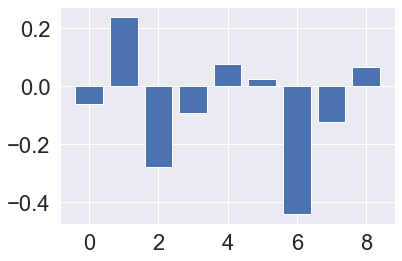

              precision    recall  f1-score   support

          50       0.28      0.29      0.29        24
          55       0.31      0.27      0.29        37
          60       0.33      0.32      0.33        34
          65       0.29      0.35      0.31        23

    accuracy                           0.31       118
   macro avg       0.30      0.31      0.30       118
weighted avg       0.31      0.31      0.30       118

Feature: 0, Score: 0.08411
Feature: 1, Score: -0.37111
Feature: 2, Score: -0.29742
Feature: 3, Score: -0.01830
Feature: 4, Score: 0.12257
Feature: 5, Score: 0.08149
Feature: 6, Score: -0.52423
Feature: 7, Score: -0.25196
Feature: 8, Score: 0.07238


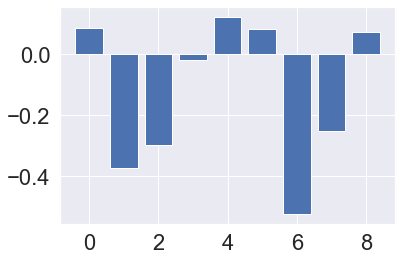

              precision    recall  f1-score   support

          50       0.28      0.32      0.30        22
          55       0.28      0.26      0.27        34
          60       0.42      0.36      0.39        39
          65       0.14      0.17      0.16        23

    accuracy                           0.29       118
   macro avg       0.28      0.28      0.28       118
weighted avg       0.30      0.29      0.29       118



In [74]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 


In [75]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,22.2
knee,1.4
exponent,22.7
center of frequency,1.2
power,1.3
bandwidth,1.1
n peaks,1.1
R2,3.0
MAE,3.0


## 2. Ridge classifier

Feature: 0, Score: -0.07265
Feature: 1, Score: -0.01613
Feature: 2, Score: -0.03829
Feature: 3, Score: -0.01204
Feature: 4, Score: 0.04446
Feature: 5, Score: 0.05947
Feature: 6, Score: -0.16489
Feature: 7, Score: -0.02837
Feature: 8, Score: 0.05817


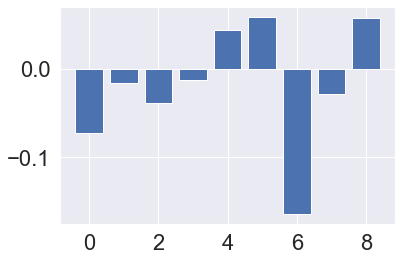

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.35      0.26      0.30        35
          55       0.31      0.31      0.31        32
          60       0.42      0.45      0.44        31
          65       0.29      0.38      0.33        21

    accuracy                           0.34       119
   macro avg       0.34      0.35      0.34       119
weighted avg       0.35      0.34      0.34       119

Feature: 0, Score: -0.11210
Feature: 1, Score: -0.03847
Feature: 2, Score: 0.02290
Feature: 3, Score: -0.02185
Feature: 4, Score: 0.06488
Feature: 5, Score: 0.02530
Feature: 6, Score: -0.17595
Feature: 7, Score: -0.10494
Feature: 8, Score: -0.00377


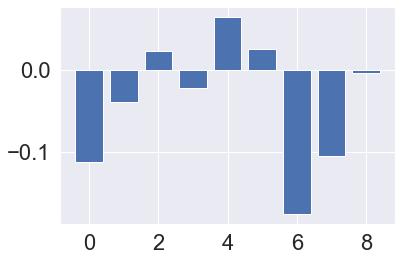

Alpha: 2.320794416806396
              precision    recall  f1-score   support

          50       0.38      0.48      0.43        21
          55       0.28      0.30      0.29        30
          60       0.36      0.31      0.33        39
          65       0.21      0.21      0.21        29

    accuracy                           0.31       119
   macro avg       0.31      0.32      0.31       119
weighted avg       0.31      0.31      0.31       119

Feature: 0, Score: -0.05821
Feature: 1, Score: -0.01618
Feature: 2, Score: -0.03121
Feature: 3, Score: -0.00562
Feature: 4, Score: 0.02297
Feature: 5, Score: 0.04157
Feature: 6, Score: -0.19401
Feature: 7, Score: -0.02589
Feature: 8, Score: 0.03902


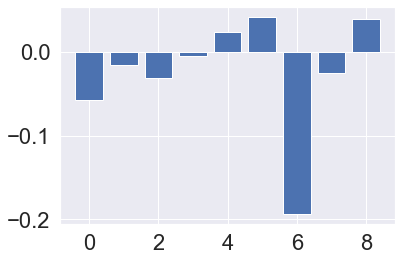

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.28      0.30      0.29        23
          55       0.27      0.30      0.29        30
          60       0.44      0.41      0.42        34
          65       0.28      0.25      0.26        32

    accuracy                           0.32       119
   macro avg       0.32      0.32      0.32       119
weighted avg       0.32      0.32      0.32       119

Feature: 0, Score: -0.05168
Feature: 1, Score: 0.04877
Feature: 2, Score: -0.05914
Feature: 3, Score: -0.02152
Feature: 4, Score: 0.03889
Feature: 5, Score: 0.01501
Feature: 6, Score: -0.15295
Feature: 7, Score: -0.06797
Feature: 8, Score: 0.00703


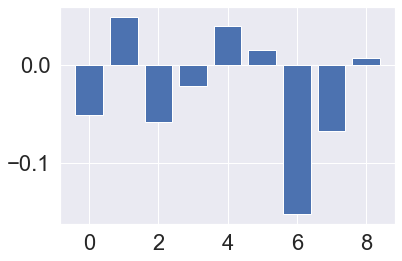

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.32      0.31      0.31        26
          55       0.16      0.21      0.18        24
          60       0.39      0.29      0.33        45
          65       0.29      0.35      0.31        23

    accuracy                           0.29       118
   macro avg       0.29      0.29      0.28       118
weighted avg       0.31      0.29      0.29       118

Feature: 0, Score: -0.02907
Feature: 1, Score: -0.04416
Feature: 2, Score: -0.06268
Feature: 3, Score: 0.00023
Feature: 4, Score: 0.05743
Feature: 5, Score: 0.03291
Feature: 6, Score: -0.16883
Feature: 7, Score: -0.07114
Feature: 8, Score: 0.02237


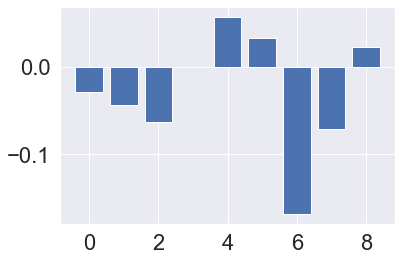

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.28      0.30      0.29        23
          55       0.12      0.13      0.13        31
          60       0.45      0.34      0.39        44
          65       0.18      0.25      0.21        20

    accuracy                           0.26       118
   macro avg       0.26      0.26      0.25       118
weighted avg       0.29      0.26      0.27       118



In [76]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

In [77]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
        
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.58      0.79      0.67        19
          55       0.66      0.57      0.61        37
          60       0.76      0.62      0.68        40
          65       0.61      0.74      0.67        23

    accuracy                           0.66       119
   macro avg       0.65      0.68      0.66       119
weighted avg       0.67      0.66      0.65       119

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.54      0.78      0.64        18
          55       0.62      0.61      0.62        33
          60       0.64      0.55      0.59        38
          65       0.75      0.70      0.72        30

    accuracy                           0.64       119
   macro avg       0.64      0.66      0.64       119
weighted avg       0.65      0.64      0.64       119

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.60      0

## 4. Multi-layer perceptron

In [78]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: tanh
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.58      0.65      0.61        23
          55       0.53      0.57      0.55        30
          60       0.73      0.69      0.71        35
          65       0.68      0.61      0.64        31

    accuracy                           0.63       119
   macro avg       0.63      0.63      0.63       119
weighted avg       0.64      0.63      0.63       119

Activation function: tanh
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.65      0.71      0.68        24
          55       0.62      0.62      0.62        32
          60       0.64      0.62      0.63        34
          65       0.79      0.76      0.77        29

    accuracy                           0.67       119
   macro avg       0.68      0.68      0.68       119
weighted avg       0.67      0.67      0.67       119

Activation function: tanh
Solver: lbfgs
          

## 5. Random forest

Feature: 0, Score: 0.12366
Feature: 1, Score: 0.14643
Feature: 2, Score: 0.13836
Feature: 3, Score: 0.10932
Feature: 4, Score: 0.10231
Feature: 5, Score: 0.02871
Feature: 6, Score: 0.04716
Feature: 7, Score: 0.15202
Feature: 8, Score: 0.15204


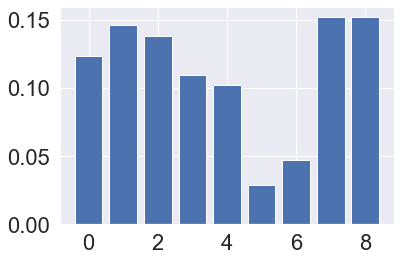

Number of trees: 200
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.77      0.77      0.77        26
          55       0.84      0.77      0.81        35
          60       0.88      0.83      0.85        35
          65       0.71      0.87      0.78        23

    accuracy                           0.81       119
   macro avg       0.80      0.81      0.80       119
weighted avg       0.81      0.81      0.81       119

Feature: 0, Score: 0.12083
Feature: 1, Score: 0.13298
Feature: 2, Score: 0.13925
Feature: 3, Score: 0.12587
Feature: 4, Score: 0.10857
Feature: 5, Score: 0.02706
Feature: 6, Score: 0.04859
Feature: 7, Score: 0.15359
Feature: 8, Score: 0.14326


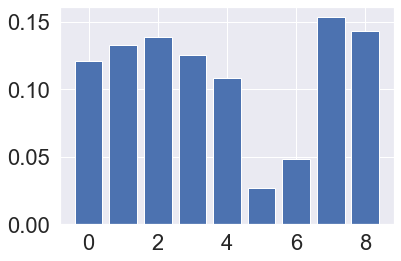

Number of trees: 200
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.69      0.82      0.75        22
          55       0.97      0.86      0.91        36
          60       0.79      0.90      0.84        29
          65       0.82      0.72      0.77        32

    accuracy                           0.82       119
   macro avg       0.82      0.82      0.82       119
weighted avg       0.83      0.82      0.83       119

Feature: 0, Score: 0.12668
Feature: 1, Score: 0.13258
Feature: 2, Score: 0.14069
Feature: 3, Score: 0.11364
Feature: 4, Score: 0.10453
Feature: 5, Score: 0.02992
Feature: 6, Score: 0.04783
Feature: 7, Score: 0.14623
Feature: 8, Score: 0.15790


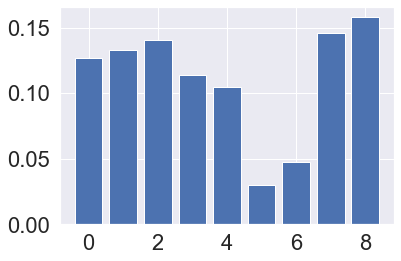

Number of trees: 200
Maximum depth: 32
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.76      0.83      0.79        23
          55       0.94      0.97      0.95        32
          60       0.88      0.85      0.86        33
          65       0.83      0.77      0.80        31

    accuracy                           0.86       119
   macro avg       0.85      0.85      0.85       119
weighted avg       0.86      0.86      0.86       119

Feature: 0, Score: 0.12288
Feature: 1, Score: 0.14767
Feature: 2, Score: 0.14549
Feature: 3, Score: 0.09794
Feature: 4, Score: 0.10874
Feature: 5, Score: 0.02409
Feature: 6, Score: 0.04725
Feature: 7, Score: 0.15645
Feature: 8, Score: 0.14949


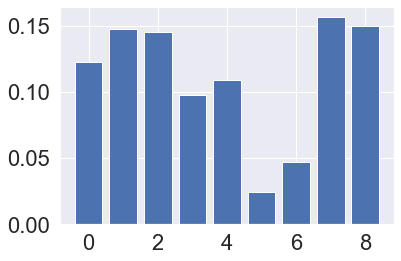

Number of trees: 200
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.72      0.82      0.77        22
          55       0.88      0.88      0.88        32
          60       0.88      0.88      0.88        33
          65       0.93      0.84      0.88        31

    accuracy                           0.86       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.86      0.86      0.86       118

Feature: 0, Score: 0.12467
Feature: 1, Score: 0.13582
Feature: 2, Score: 0.14479
Feature: 3, Score: 0.10381
Feature: 4, Score: 0.10449
Feature: 5, Score: 0.02490
Feature: 6, Score: 0.04937
Feature: 7, Score: 0.16137
Feature: 8, Score: 0.15078


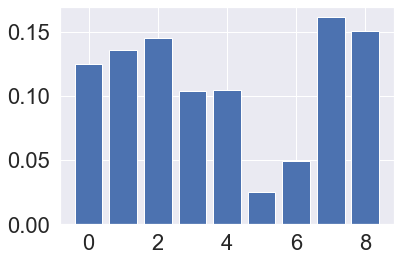

Number of trees: 2000
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.64      0.84      0.73        19
          55       0.78      0.81      0.79        31
          60       0.82      0.82      0.82        33
          65       0.96      0.77      0.86        35

    accuracy                           0.81       118
   macro avg       0.80      0.81      0.80       118
weighted avg       0.82      0.81      0.81       118

Done in 1597.4513192176819 seconds


In [79]:
tic = time.time()

# Initialize dataframe
importances = pd.DataFrame([], index = [], columns = ['offset', 'knee', 'exponent', 'frequency', 'power', 'bandwidth', \
                                                      'n peaks', 'MAE', 'R2'])
# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    importances = importances.append(pd.DataFrame(importance, index = ['offset', 'knee', 'exponent', 'frequency', 'power', \
                                                                       'bandwidth', 'n peaks', 'MAE', 'R2']).transpose(), \
                                     ignore_index=False)
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 
    
print(f'Done in {time.time()-tic} seconds')

Text(0, 0.5, 'Gini importances')

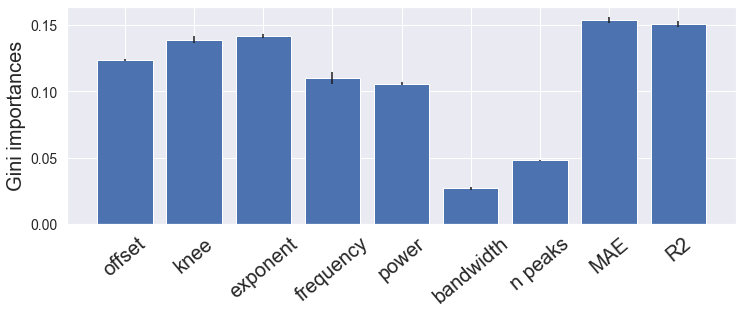

In [80]:
# Histograms importances features
tick = ['offset', 'knee', 'exponent', 'frequency', 'power', 'bandwidth', 'n peaks', 'MAE', 'R2']
RF_imp = np.mean(importances, axis=0)
RF_imp_std = np.std(importances, axis=0)/sqrt(5)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize =(12, 4))
plt.bar(np.arange(len(RF_imp)),RF_imp, yerr=RF_imp_std, tick_label=tick)
plt.xticks(rotation=40, fontsize = 20)
plt.yticks(fontsize = 14)
ax.set_ylabel('Gini importances', fontsize = 20)

# Same for 3 channels
# I. Preparation

In [81]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [82]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
        # Fit FOOOF model per target
        for (powers, target) in zip((powers_50, powers_55, powers_60, powers_65), \
                                    (50, 55, 60, 65)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=False)[0][0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[0][0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[0][1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[0][2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=False)[1][0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[1][0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[1][1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[1][2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=False)[2][0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[2][0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[2][1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=False)[2][2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    3.7756, 1955.7955, 3.1439                                     
                                                              

C:\Users\ThinkPad\anaconda3\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


S27 /Day1 cnt_HIGH(2).mat
S27 /Day1 cnt_LOW(1).mat
S27 /Day1 cnt_LOW(2).mat
S27 /Day1 cnt_MID(1).mat
S27 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     1.6968, -1.2672, 1.4712                                      
                                                                                  

# IV. Classification
## Assign variables

In [83]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 0.18408
Feature: 1, Score: 7.79593
Feature: 2, Score: -0.51967
Feature: 3, Score: -0.03900
Feature: 4, Score: 0.10561
Feature: 5, Score: 0.03924
Feature: 6, Score: -0.37203
Feature: 7, Score: 0.00990
Feature: 8, Score: 0.17220


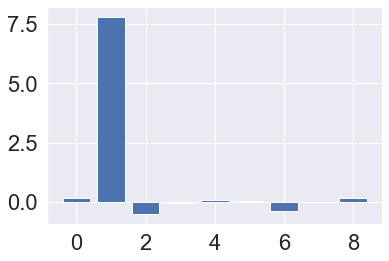

              precision    recall  f1-score   support

          50       0.30      0.40      0.34        40
          55       0.22      0.34      0.26        41
          60       0.51      0.48      0.50        73
          65       0.49      0.32      0.39        91

    accuracy                           0.38       245
   macro avg       0.38      0.38      0.37       245
weighted avg       0.42      0.38      0.39       245

Feature: 0, Score: 0.19815
Feature: 1, Score: 1.94421
Feature: 2, Score: -0.52116
Feature: 3, Score: -0.06450
Feature: 4, Score: 0.12127
Feature: 5, Score: 0.00663
Feature: 6, Score: -0.39786
Feature: 7, Score: -0.02926
Feature: 8, Score: 0.14996


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


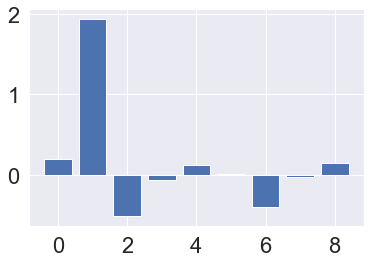

              precision    recall  f1-score   support

          50       0.26      0.30      0.28        47
          55       0.22      0.21      0.21        66
          60       0.43      0.43      0.43        67
          65       0.41      0.38      0.39        64

    accuracy                           0.33       244
   macro avg       0.33      0.33      0.33       244
weighted avg       0.33      0.33      0.33       244

Feature: 0, Score: 0.10829
Feature: 1, Score: 36.76712
Feature: 2, Score: -0.50562
Feature: 3, Score: -0.04094
Feature: 4, Score: 0.05011
Feature: 5, Score: 0.08324
Feature: 6, Score: -0.38140
Feature: 7, Score: 0.01469
Feature: 8, Score: 0.22052


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


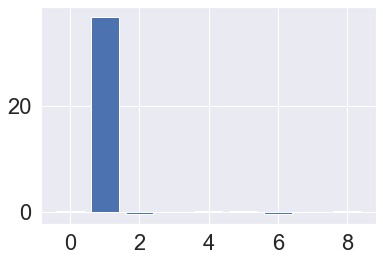

              precision    recall  f1-score   support

          50       0.36      0.33      0.35        57
          55       0.22      0.25      0.23        57
          60       0.45      0.45      0.45        69
          65       0.38      0.36      0.37        61

    accuracy                           0.35       244
   macro avg       0.35      0.35      0.35       244
weighted avg       0.36      0.35      0.35       244



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 0.42929
Feature: 1, Score: 0.95917
Feature: 2, Score: -0.71653
Feature: 3, Score: -0.02730
Feature: 4, Score: 0.03378
Feature: 5, Score: 0.04321
Feature: 6, Score: -0.40367
Feature: 7, Score: 0.00374
Feature: 8, Score: 0.15403


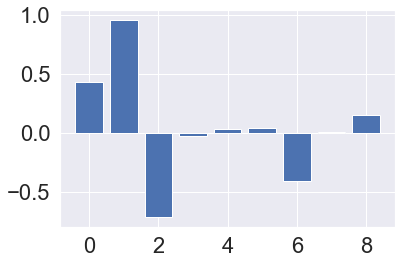

              precision    recall  f1-score   support

          50       0.32      0.40      0.35        43
          55       0.25      0.28      0.26        57
          60       0.43      0.39      0.41        76
          65       0.47      0.40      0.43        68

    accuracy                           0.37       244
   macro avg       0.37      0.37      0.37       244
weighted avg       0.38      0.37      0.37       244

Feature: 0, Score: 0.31994
Feature: 1, Score: -18.25026
Feature: 2, Score: -0.61954
Feature: 3, Score: -0.05053
Feature: 4, Score: 0.08325
Feature: 5, Score: 0.03918
Feature: 6, Score: -0.34108
Feature: 7, Score: -0.08366
Feature: 8, Score: 0.10479


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


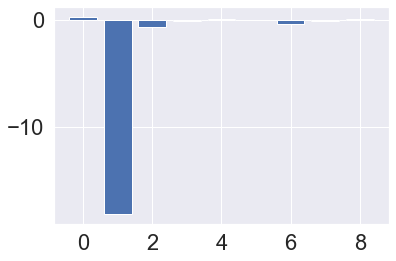

              precision    recall  f1-score   support

          50       0.29      0.36      0.32        42
          55       0.18      0.27      0.22        45
          60       0.51      0.43      0.47        81
          65       0.42      0.33      0.37        76

    accuracy                           0.36       244
   macro avg       0.35      0.35      0.34       244
weighted avg       0.39      0.36      0.37       244



In [84]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [85]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,27.1
knee,1.1
exponent,27.2
center of frequency,1.2
power,1.3
bandwidth,1.1
n peaks,1.1
R2,2.6
MAE,2.9


## 2. Ridge classifier

Feature: 0, Score: 0.06050
Feature: 1, Score: 0.00208
Feature: 2, Score: -0.18748
Feature: 3, Score: -0.01320
Feature: 4, Score: 0.05967
Feature: 5, Score: 0.01989
Feature: 6, Score: -0.13884
Feature: 7, Score: 0.00059
Feature: 8, Score: 0.05357


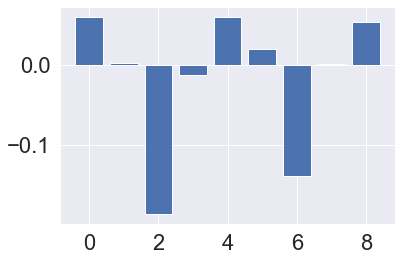

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

          50       0.32      0.41      0.36        41
          55       0.15      0.38      0.22        26
          60       0.53      0.44      0.48        82
          65       0.47      0.29      0.36        96

    accuracy                           0.37       245
   macro avg       0.37      0.38      0.36       245
weighted avg       0.43      0.37      0.39       245

Feature: 0, Score: -0.02641
Feature: 1, Score: -0.00120
Feature: 2, Score: -0.09059
Feature: 3, Score: -0.02020
Feature: 4, Score: 0.06866
Feature: 5, Score: 0.00621
Feature: 6, Score: -0.13785
Feature: 7, Score: -0.02227
Feature: 8, Score: 0.04107


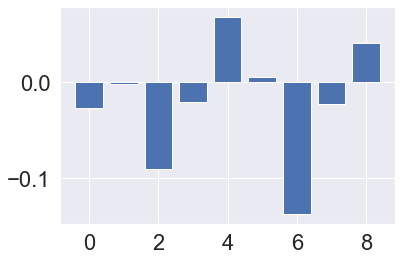

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.32      0.33      0.33        51
          55       0.14      0.19      0.16        47
          60       0.51      0.40      0.45        87
          65       0.36      0.36      0.36        59

    accuracy                           0.34       244
   macro avg       0.33      0.32      0.32       244
weighted avg       0.36      0.34      0.35       244

Feature: 0, Score: 0.04015
Feature: 1, Score: 0.00155
Feature: 2, Score: -0.17484
Feature: 3, Score: -0.01574
Feature: 4, Score: 0.04237
Feature: 5, Score: 0.03854
Feature: 6, Score: -0.13764
Feature: 7, Score: -0.01594
Feature: 8, Score: 0.05212


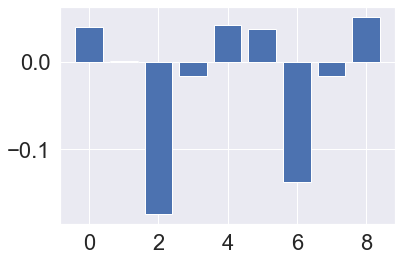

Alpha: 2.320794416806396
              precision    recall  f1-score   support

          50       0.30      0.32      0.31        50
          55       0.12      0.22      0.16        37
          60       0.49      0.40      0.44        86
          65       0.40      0.32      0.36        71

    accuracy                           0.33       244
   macro avg       0.33      0.31      0.32       244
weighted avg       0.37      0.33      0.35       244

Feature: 0, Score: 0.13851
Feature: 1, Score: -0.00176
Feature: 2, Score: -0.25102
Feature: 3, Score: -0.01179
Feature: 4, Score: 0.02968
Feature: 5, Score: 0.02198
Feature: 6, Score: -0.14731
Feature: 7, Score: 0.00738
Feature: 8, Score: 0.04835


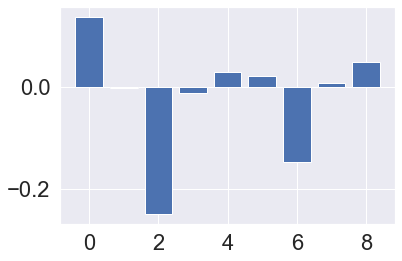

Alpha: 2.320794416806396
              precision    recall  f1-score   support

          50       0.34      0.39      0.36        46
          55       0.12      0.24      0.16        33
          60       0.51      0.38      0.43        92
          65       0.48      0.38      0.43        73

    accuracy                           0.36       244
   macro avg       0.36      0.35      0.35       244
weighted avg       0.42      0.36      0.38       244

Feature: 0, Score: 0.09197
Feature: 1, Score: 0.00227
Feature: 2, Score: -0.22609
Feature: 3, Score: -0.01508
Feature: 4, Score: 0.04804
Feature: 5, Score: 0.02160
Feature: 6, Score: -0.12234
Feature: 7, Score: -0.02443
Feature: 8, Score: 0.03231


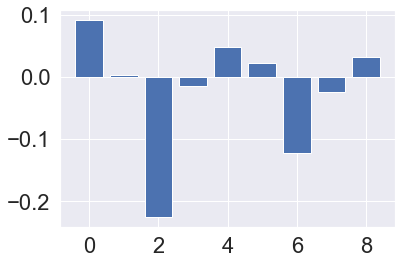

Alpha: 2.320794416806396
              precision    recall  f1-score   support

          50       0.31      0.35      0.33        46
          55       0.06      0.16      0.09        25
          60       0.62      0.44      0.51        96
          65       0.39      0.30      0.34        77

    accuracy                           0.35       244
   macro avg       0.34      0.31      0.32       244
weighted avg       0.43      0.35      0.38       244



In [86]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: -0.00408
Feature: 1, Score: 0.01878
Feature: 2, Score: -0.01796
Feature: 3, Score: -0.00408
Feature: 4, Score: -0.01469
Feature: 5, Score: -0.00163
Feature: 6, Score: 0.00163
Feature: 7, Score: -0.00327
Feature: 8, Score: -0.00327


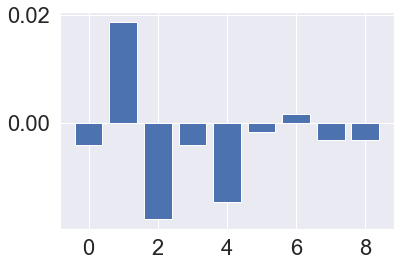

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.58      0.67      0.63        46
          55       0.68      0.64      0.66        69
          60       0.71      0.76      0.73        63
          65       0.75      0.66      0.70        67

    accuracy                           0.68       245
   macro avg       0.68      0.68      0.68       245
weighted avg       0.69      0.68      0.68       245

Feature: 0, Score: -0.00656
Feature: 1, Score: -0.00328
Feature: 2, Score: -0.00492
Feature: 3, Score: -0.00410
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00410
Feature: 6, Score: -0.00328
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


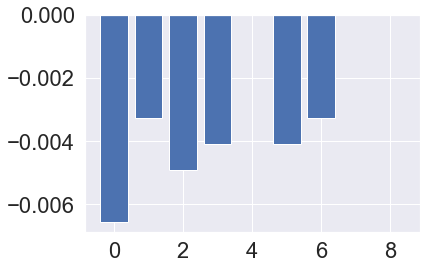

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.64      0.76      0.69        45
          55       0.82      0.74      0.77        72
          60       0.75      0.71      0.73        72
          65       0.78      0.82      0.80        55

    accuracy                           0.75       244
   macro avg       0.75      0.75      0.75       244
weighted avg       0.76      0.75      0.75       244

Feature: 0, Score: -0.01230
Feature: 1, Score: 0.01475
Feature: 2, Score: 0.00246
Feature: 3, Score: -0.00246
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00328
Feature: 6, Score: 0.00328
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


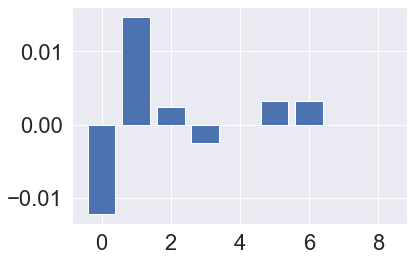

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.74      0.74      0.74        53
          55       0.84      0.72      0.78        75
          60       0.65      0.80      0.72        56
          65       0.76      0.73      0.75        60

    accuracy                           0.75       244
   macro avg       0.75      0.75      0.74       244
weighted avg       0.76      0.75      0.75       244

Feature: 0, Score: 0.00492
Feature: 1, Score: 0.00410
Feature: 2, Score: 0.00410
Feature: 3, Score: -0.00328
Feature: 4, Score: 0.00082
Feature: 5, Score: -0.00492
Feature: 6, Score: -0.00164
Feature: 7, Score: -0.00164
Feature: 8, Score: -0.00246


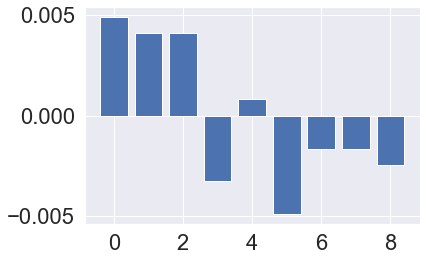

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.70      0.63      0.66        59
          55       0.59      0.62      0.61        61
          60       0.68      0.67      0.68        70
          65       0.64      0.69      0.66        54

    accuracy                           0.65       244
   macro avg       0.65      0.65      0.65       244
weighted avg       0.65      0.65      0.65       244

Feature: 0, Score: -0.00164
Feature: 1, Score: 0.00820
Feature: 2, Score: -0.00082
Feature: 3, Score: 0.00000
Feature: 4, Score: -0.00246
Feature: 5, Score: -0.00492
Feature: 6, Score: -0.00738
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


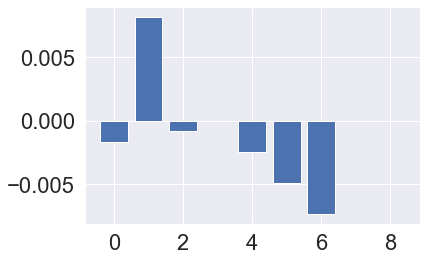

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.75      0.76      0.76        51
          55       0.66      0.80      0.72        54
          60       0.76      0.67      0.71        78
          65       0.83      0.80      0.82        61

    accuracy                           0.75       244
   macro avg       0.75      0.76      0.75       244
weighted avg       0.76      0.75      0.75       244



In [87]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [88]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.66      0.67      0.67        52
          55       0.69      0.63      0.66        71
          60       0.66      0.75      0.70        60
          65       0.76      0.73      0.74        62

    accuracy                           0.69       245
   macro avg       0.69      0.70      0.69       245
weighted avg       0.70      0.69      0.69       245



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.77      0.75      0.76        55
          55       0.71      0.71      0.71        65
          60       0.74      0.72      0.73        69
          65       0.71      0.75      0.73        55

    accuracy                           0.73       244
   macro avg       0.73      0.73      0.73       244
weighted avg       0.73      0.73      0.73       244



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.70      0.76      0.73        49
          55       0.88      0.73      0.79        77
          60       0.62      0.78      0.69        55
          65       0.76      0.70      0.73        63

    accuracy                           0.74       244
   macro avg       0.74      0.74      0.74       244
weighted avg       0.75      0.74      0.74       244



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.75      0.62      0.68        64
          55       0.62      0.67      0.65        60
          60       0.58      0.63      0.61        63
          65       0.66      0.67      0.66        57

    accuracy                           0.65       244
   macro avg       0.65      0.65      0.65       244
weighted avg       0.65      0.65      0.65       244



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.73      0.68      0.70        56
          55       0.60      0.72      0.66        54
          60       0.68      0.62      0.65        74
          65       0.81      0.80      0.81        60

    accuracy                           0.70       244
   macro avg       0.71      0.71      0.70       244
weighted avg       0.71      0.70      0.70       244



## 5. Random forest

Feature: 0, Score: 0.12295
Feature: 1, Score: 0.12791
Feature: 2, Score: 0.12489
Feature: 3, Score: 0.14081
Feature: 4, Score: 0.11670
Feature: 5, Score: 0.03530
Feature: 6, Score: 0.04584
Feature: 7, Score: 0.14219
Feature: 8, Score: 0.14341


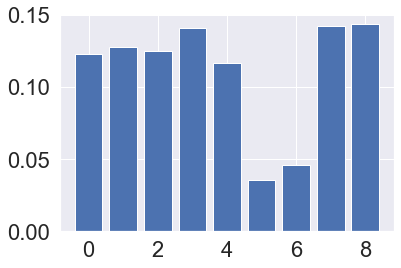

Number of trees: 2000
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.83      0.81      0.82        54
          55       0.89      0.89      0.89        65
          60       0.81      0.93      0.87        59
          65       0.93      0.82      0.87        67

    accuracy                           0.87       245
   macro avg       0.87      0.87      0.86       245
weighted avg       0.87      0.87      0.87       245

Feature: 0, Score: 0.12756
Feature: 1, Score: 0.13201
Feature: 2, Score: 0.12625
Feature: 3, Score: 0.14136
Feature: 4, Score: 0.10936
Feature: 5, Score: 0.03281
Feature: 6, Score: 0.04608
Feature: 7, Score: 0.13466
Feature: 8, Score: 0.14991


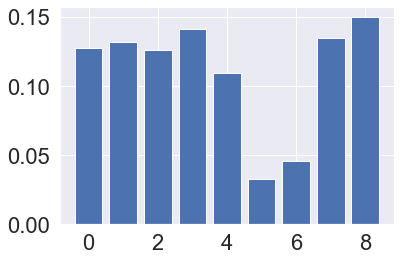

Number of trees: 200
Maximum depth: 77
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.83      0.86      0.85        51
          55       0.88      0.86      0.87        66
          60       0.84      0.92      0.88        62
          65       0.93      0.83      0.88        65

    accuracy                           0.87       244
   macro avg       0.87      0.87      0.87       244
weighted avg       0.87      0.87      0.87       244

Feature: 0, Score: 0.12268
Feature: 1, Score: 0.13508
Feature: 2, Score: 0.13101
Feature: 3, Score: 0.13611
Feature: 4, Score: 0.10613
Feature: 5, Score: 0.03222
Feature: 6, Score: 0.04556
Feature: 7, Score: 0.14265
Feature: 8, Score: 0.14857


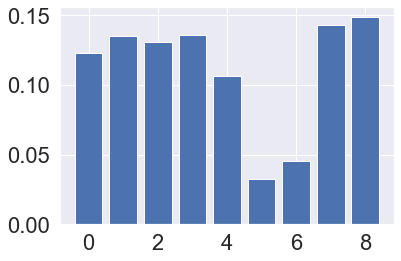

Number of trees: 2000
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.81      0.81      0.81        53
          55       0.91      0.84      0.87        69
          60       0.78      0.93      0.85        58
          65       0.90      0.81      0.85        64

    accuracy                           0.85       244
   macro avg       0.85      0.85      0.85       244
weighted avg       0.85      0.85      0.85       244

Feature: 0, Score: 0.12277
Feature: 1, Score: 0.13260
Feature: 2, Score: 0.12537
Feature: 3, Score: 0.13454
Feature: 4, Score: 0.11392
Feature: 5, Score: 0.03363
Feature: 6, Score: 0.04704
Feature: 7, Score: 0.14273
Feature: 8, Score: 0.14739


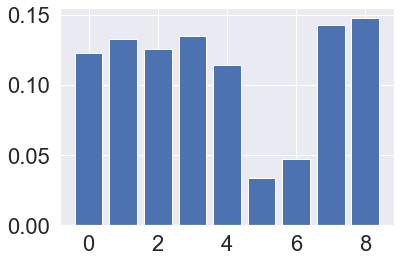

Number of trees: 200
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.91      0.89      0.90        54
          55       0.86      0.96      0.91        57
          60       0.90      0.91      0.91        68
          65       0.98      0.88      0.93        65

    accuracy                           0.91       244
   macro avg       0.91      0.91      0.91       244
weighted avg       0.91      0.91      0.91       244

Feature: 0, Score: 0.12101
Feature: 1, Score: 0.13387
Feature: 2, Score: 0.12947
Feature: 3, Score: 0.13452
Feature: 4, Score: 0.10932
Feature: 5, Score: 0.03169
Feature: 6, Score: 0.04394
Feature: 7, Score: 0.14130
Feature: 8, Score: 0.15488


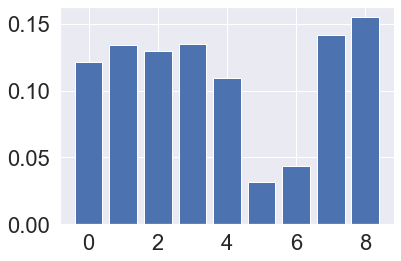

Number of trees: 1000
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.77      0.85      0.81        47
          55       0.83      0.89      0.86        61
          60       0.88      0.87      0.88        69
          65       0.97      0.85      0.90        67

    accuracy                           0.86       244
   macro avg       0.86      0.86      0.86       244
weighted avg       0.87      0.86      0.87       244

Done in 963.4165878295898 seconds


In [89]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    
    
print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [90]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table8.csv')
performance.to_csv('performance_table8.csv')

# Display
display(performance)
display(df)

,accuracy,precision,recall,classifier,n_channels,table
0,0.32,0.33,0.32,log,13,8
1,0.34,0.34,0.34,log,13,8
2,0.29,0.29,0.29,log,13,8
3,0.31,0.31,0.31,log,13,8
4,0.29,0.30,0.29,log,13,8
5,0.34,0.35,0.34,ridge,13,8
6,0.31,0.31,0.31,ridge,13,8
7,0.32,0.32,0.32,ridge,13,8
8,0.29,0.31,0.29,ridge,13,8
9,0.26,0.29,0.26,ridge,13,8


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,50,2.487202,102.662804,2.074514,9.505280,0.826092,2.369051,1,0.947597,0.080683
1,S1,/Day1,55,3.765459,2005.550537,3.199116,9.215099,0.817649,2.000000,3,0.955425,0.065216
2,S1,/Day1,55,3.765459,2005.550537,3.199116,9.215099,0.817649,2.000000,3,0.955425,0.065216
3,S1,/Day1,55,3.765459,2005.550537,3.199116,11.180996,0.279208,2.000000,3,0.955425,0.065216
4,S1,/Day1,55,3.765459,2005.550537,3.199116,18.464607,0.414522,3.003062,3,0.955425,0.065216
...,...,...,...,...,...,...,...,...,...,...,...,...
1216,S30,/Day2,55,1.943061,9.971169,1.550166,10.953539,0.162534,2.000000,2,0.943335,0.062469
1217,S30,/Day2,60,2.142327,19.028496,1.654540,6.716576,0.320796,2.000000,2,0.907675,0.080437
1218,S30,/Day2,60,2.142327,19.028496,1.654540,6.716576,0.320796,2.000000,2,0.907675,0.080437
1219,S30,/Day2,60,2.142327,19.028496,1.654540,11.549206,0.124805,2.000000,2,0.907675,0.080437


In [91]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.716     0.724  0.716
           13            0.610     0.618  0.610
MLP        3             0.702     0.708  0.702
           13            0.614     0.620  0.614
RF         3             0.872     0.874  0.872
           13            0.832     0.836  0.832
log        3             0.358     0.376  0.358
           13            0.310     0.314  0.310
ridge      3             0.350     0.402  0.350
           13            0.304     0.316  0.304

log 13


accuracy     0.008485
precision    0.008295
recall       0.008485
dtype: float64

log 3


accuracy     0.007694
precision    0.013446
recall       0.007694
dtype: float64

Ridge 13


accuracy     0.012198
precision    0.008764
recall       0.012198
dtype: float64

Ridge 3


accuracy     0.006325
precision    0.013682
recall       0.006325
dtype: float64

KNN 13


accuracy     0.020000
precision    0.021615
recall       0.020000
dtype: float64

KNN 3


accuracy     0.019100
precision    0.020513
recall       0.019100
dtype: float64

MLP 13


accuracy     0.015126
precision    0.013856
recall       0.015126
dtype: float64

MLP 3


accuracy     0.014255
precision    0.015073
recall       0.014255
dtype: float64

RF 13


accuracy     0.010354
precision    0.009209
recall       0.010354
dtype: float64

RF 3


accuracy     0.009121
precision    0.008764
recall       0.009121
dtype: float64

In [92]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),2.106108,4.0,493.464634,1.881680e-33
C(n_channels),0.053792,1.0,50.414228,1.360305e-08
C(classifier):C(n_channels),0.008708,4.0,2.040298,1.070612e-01
Residual,0.042680,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   KNN    MLP   -0.005   0.9 -0.0664  0.0564  False
   KNN     RF    0.189 0.001  0.1276  0.2504   True
   KNN    log   -0.329 0.001 -0.3904 -0.2676   True
   KNN  ridge   -0.336 0.001 -0.3974 -0.2746   True
   MLP     RF    0.194 0.001  0.1326  0.2554   True
   MLP    log   -0.324 0.001 -0.3854 -0.2626   True
   MLP  ridge   -0.331 0.001 -0.3924 -0.2696   True
    RF    log   -0.518 0.001 -0.5794 -0.4566   True
    RF  ridge   -0.525 0.001 -0.5864 -0.4636   True
   log  ridge   -0.007   0.9 -0.0684  0.0544  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
     3     13  -0.0656 0.2794 -0.1862 0.055  False
--------------------------------------------------


,sum_sq,df,F,PR(>F)
C(classifier),1.950208,4.0,393.504339,1.566324e-31
C(n_channels),0.072200,1.0,58.272788,2.496733e-09
C(classifier):C(n_channels),0.006960,4.0,1.404358,2.500440e-01
Residual,0.049560,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   KNN    MLP   -0.007   0.9 -0.075  0.061  False
   KNN     RF    0.184 0.001  0.116  0.252   True
   KNN    log   -0.326 0.001 -0.394 -0.258   True
   KNN  ridge   -0.312 0.001  -0.38 -0.244   True
   MLP     RF    0.191 0.001  0.123  0.259   True
   MLP    log   -0.319 0.001 -0.387 -0.251   True
   MLP  ridge   -0.305 0.001 -0.373 -0.237   True
    RF    log    -0.51 0.001 -0.578 -0.442   True
    RF  ridge   -0.496 0.001 -0.564 -0.428   True
   log  ridge    0.014   0.9 -0.054  0.082  False
-------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     3     13   -0.076 0.195 -0.1923 0.0403  False
--------------------------------------------------


,sum_sq,df,F,PR(>F)
C(classifier),2.106108,4.0,493.464634,1.881680e-33
C(n_channels),0.053792,1.0,50.414228,1.360305e-08
C(classifier):C(n_channels),0.008708,4.0,2.040298,1.070612e-01
Residual,0.042680,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   KNN    MLP   -0.005   0.9 -0.0664  0.0564  False
   KNN     RF    0.189 0.001  0.1276  0.2504   True
   KNN    log   -0.329 0.001 -0.3904 -0.2676   True
   KNN  ridge   -0.336 0.001 -0.3974 -0.2746   True
   MLP     RF    0.194 0.001  0.1326  0.2554   True
   MLP    log   -0.324 0.001 -0.3854 -0.2626   True
   MLP  ridge   -0.331 0.001 -0.3924 -0.2696   True
    RF    log   -0.518 0.001 -0.5794 -0.4566   True
    RF  ridge   -0.525 0.001 -0.5864 -0.4636   True
   log  ridge   -0.007   0.9 -0.0684  0.0544  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
     3     13  -0.0656 0.2794 -0.1862 0.055  False
--------------------------------------------------
